In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

c:\Users\zhant\.conda\envs\sqt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

In [3]:
model_spec = SpectrumPredictor.load_from_checkpoint("production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt")
print(model_spec)

SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=False)
  )
)


In [6]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
train_indices = indices_dict['train']
val_indices = indices_dict['val']
test_indices = indices_dict['test']

X_train = X[train_indices]
Y_train = Y[train_indices]
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test = X[test_indices]
Y_test = Y[test_indices]

print("print some values for further reference:")
# print("training:\n", X_train[:5])
# print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

print some values for further reference:
testing:
 tensor([[-1.5924e+00, -2.1911e-01],
        [-2.9503e+00, -8.5994e-04],
        [-1.6105e+00, -2.4190e-01],
        [-2.3308e+00, -4.2538e-01],
        [-1.8445e+00, -5.6670e-01]])


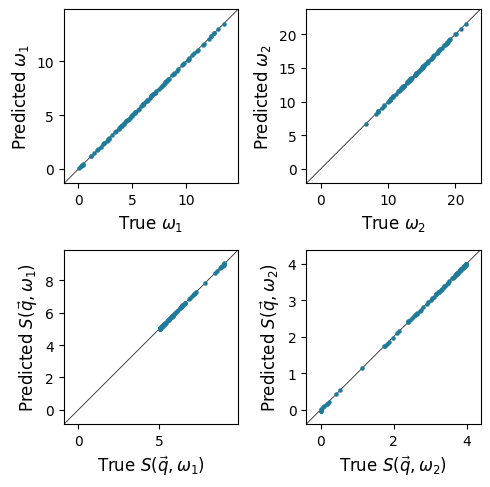

In [7]:
model_spec.to(device)

loss_test = []
Y_test_pred = []
with torch.no_grad():
    for x_test, y_test in zip(X_test, Y_test):
        y_test_pred = model_spec(x_test.to(device)).detach().cpu()
        loss_test.append((y_test_pred - y_test).abs().mean().item())
        Y_test_pred.append(y_test_pred)
Y_test_pred = torch.vstack(Y_test_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S(\vec{q},\omega_{1})$', r'$S(\vec{q},\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="#207A9A", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
# fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')

In [8]:
gamma = 0.1
# times = np.arange(0,3,0.01)
times = np.linspace(0, 3, 121)
settings = (times, )
n_particles = 101
parameters = (
    np.random.uniform(-3.0, -1.0, n_particles),
    np.random.uniform(-1.0,-0.0, n_particles),
    np.random.uniform( 0.0, 1.0, n_particles),
    np.random.uniform( 0.0, 10.0, n_particles),
    np.random.uniform( 0.1, 2.0, n_particles)
    )

In [9]:
%load_ext autoreload
%autoreload 2
from src.bayes import BayesianInference, jit_batch_spec_to_Sqt
from src.utils_model import tensor2array, array2tensor
import optbayesexpt as obe
from src.utils_convolution import get_I_conv, interp_nb

In [10]:
from src.utils_general import prepare_sample

def measure_function(sets, pars, cons, func):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
    I_pred = func(t)
    return I_pred

In [11]:
target_idx = 40

pulse_width = 0.1
noise_level = 1
N_steps_bayes = 70
normalize_to_value = 100

c:\Users\zhant\Dropbox\SLAC\publications\Sqt_ML_ExptSteering\submissions\ML-XPFS_Steering\src\utils_convolution.py:19: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):


[-1.78435064 -0.76653415  0.1         3.02493167  0.5       ]


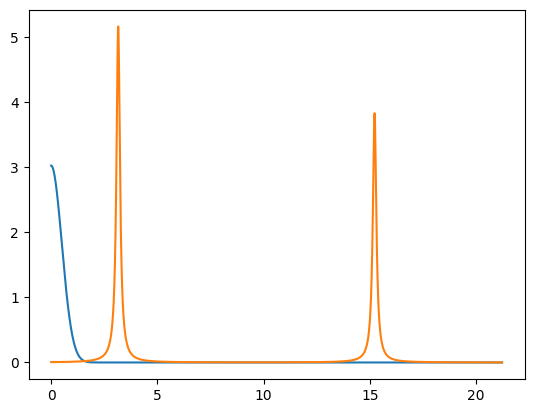

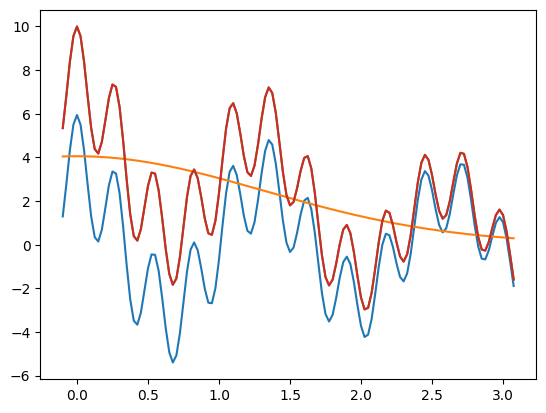

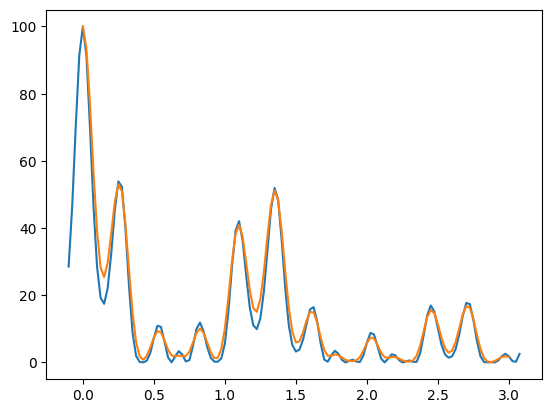

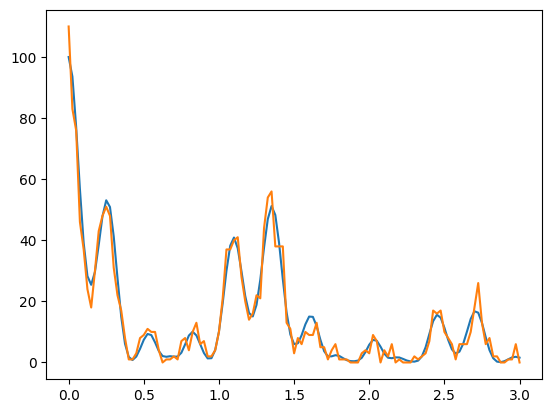

In [12]:
param_true, func_I_conv, func_I_noconv = \
    prepare_sample(X_test[target_idx], Y_test[target_idx], gamma, times, 
                   pulse_width=pulse_width, visualize=True, normalize_to_value=normalize_to_value,
                   elas_amp_factor=0.5850576985324748, elas_wid=0.5, elas_amp_abs_max=1000.)
print(param_true)
obe_sim = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level, noise_mode='poisson')
obe_sim_noisefree = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=0)

plt.figure()
plt.plot(times, obe_sim_noisefree.simdata((times,)))
plt.plot(times, obe_sim.simdata((times,)))
# plt.figure()
# plt.plot(times, np.log(obe_sim.simdata((times,))))
# plt.plot(times, np.log(obe_sim_noisefree.simdata((times,))))

In [13]:
from src.bayes import BayesianInference
bayes = BayesianInference(
    model_spec, settings, parameters, noise_level=noise_level,
    pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value),
    cost_repulse_height=10.0, cost_repulse_width=0.25,
    parameter_mins=(-3,-1,0,0,0.1), parameter_maxs=(-1,0,1,15,2), 
    selection_method='unique_optimal', utility_method='variance_full',
    model_uncertainty=False, device=device)
# bayes.obe_model.set_selection_method('unique_optimal')
# bayes.obe_model.set_selection_method('sequential')

c:\Users\zhant\Dropbox\SLAC\publications\Sqt_ML_ExptSteering\submissions\ML-XPFS_Steering\src\bayes.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),
c:\Users\zhant\Dropbox\SLAC\publications\Sqt_ML_ExptSteering\submissions\ML-XPFS_Steering\src\bayes.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),


In [14]:
# bayes.obe_model.set_selection_method('sequential')
particles_hist, p_weights_hist, errors, likyhd_hist = bayes.run_N_steps_OptBayesExpt_w_GD(
    40, obe_sim, N_GD=100, lr=0.01, ret_particles=True, verbose=False,
    gd_seperation=14, error_criterion=10)
print(bayes.obe_model.mean(), bayes.obe_model.std())

c:\Users\zhant\Dropbox\SLAC\publications\Sqt_ML_ExptSteering\submissions\ML-XPFS_Steering\src\bayes.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),
c:\Users\zhant\Dropbox\SLAC\publications\Sqt_ML_ExptSteering\submissions\ML-XPFS_Steering\src\bayes.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),
c:\Users\zhant\Dropbox\SLAC\publications\Sqt_ML_ExptSteering\submissions\ML-XPFS_Steering\src\utils_gd.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather t

[-1.78651771 -0.76852842  0.24063968  2.67496872  0.62041114] [0.0046166  0.00460193 0.0318625  0.16624924 0.0467611 ]


In [15]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)

idx_plot = -1
# utility_plot = bayes.utility_list[idx_plot]
# utility_plot = 20 * utility_plot / utility_plot.max()

measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings(param_mean[idx_plot-1])
# _, measurements_predicted = bayes.predict_all_settings(param_true)
measurements_predicted *= normalize_to_value / measurements_predicted[0]

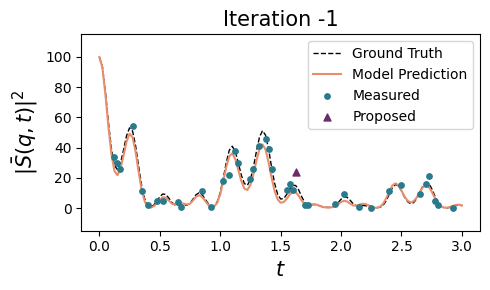

In [16]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax.plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=5)
# ax.fill_between(times.squeeze(), measurements_predicted-utility_plot, measurements_predicted+utility_plot, color=palette_flare[0], zorder=1, alpha=0.25)
ax.scatter(measured_settings.squeeze()[:idx_plot], measured_observables.squeeze()[:idx_plot], label="Measured", s=15, color=palette_crest[-3], zorder=10)
ax.scatter(measured_settings.squeeze()[idx_plot], measured_observables.squeeze()[idx_plot], label="Proposed", s=25, color=palette_flare[-1], zorder=20, marker='^')
ax.legend(fontsize=10)
ax.set_xlabel('$t$', fontsize=15)
ax.set_ylim([-15, measurements_noisefree.max()+15])
ax.set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=15)
ax.set_title(f"Iteration {idx_plot}", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_sqt_sample{idx}_iter{idx_plot}.pdf')

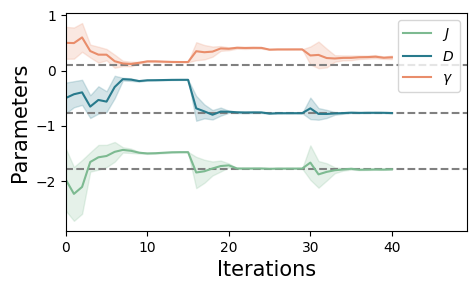

In [18]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0], palette_flare[-3], palette_flare[-1]]

label_lst = ["$J$", "$D$", "$\gamma$", "$a$", "$\sigma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))
for i in range(5):
    
    if i <= 2:
        ax.fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], color=colors[i], alpha=0.2)
        ax.hlines(param_true[i], -100, 100*maxiter, linestyles='--', color='gray')
        ax.plot(np.arange(maxiter), param_mean[:,i], color=colors[i], label=label_lst[i])
ax.set_xlim([-0.*maxiter, 1.2*maxiter])
ax.legend(loc='best', fontsize=10)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylabel("Parameters", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_paramhist_sample{idx}.pdf')